In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pickle
import scipy.optimize
import scipy.interpolate
import h5py
from readsubhalo import *


In [3]:
tick_size=20
label_font_size=30
tick_font_size=25
legend_font_size=25

c=3e8
mass_unit_conv=1e10/980/1e6
mass_sun=2e30
yr_to_sec=3.15e7
lamb=0.1
h=0.7
joule_to_ergs=1e7
total_conv=mass_unit_conv*mass_sun/yr_to_sec*c**2*joule_to_ergs*lamb

In [4]:
snapshots=['085','083','079','073','068','063','058','055','050','042','039','037','035','034','031','029','027','026','025','024','023','022','021','020','019','018','017','016','015','014','013','012','011']
global c,h,omm,oml,omk
omk=0
oml=0.693
omm=0.307
cc=3*10**5
h=0.697
from scipy.integrate import quad
import scipy.interpolate

def DC(z0, z1):
    # Comoving distance in Mpc                                                                                          $
    def integrand(z):
        return 1.0/E(z)
    return cc/(100.0)*quad(integrand,z0,z1)[0]

def E(z):
        #normalized hubble parameter                                                                                    $
    return np.sqrt(omm*(1.0+z)**3 + oml + omk*(1.0+z)**2)

def DL(z):
    #Luminosity distance in Mpcs                                                                                        $
    return (1.0+z)*DC(0,z)

def DM(z):
        #Distance Modulus                                                                                               $
        return 5*np.log10((DL(z)*1e6)/10.0)
def m_to_f_SDSS(m):
    return 10**((m-22.5)/(-2.5))


def mtoM(m,z,N):
    return m - DM(z) - (K(z)-N*K(2.))

def Mtom(M, z,N):
    return M + DM(z) + (K(z)-N*K(2.))

def LtoM(L):
    M = -2.5 * np.log10(L*1e-7)+34.1
    return M

def MtoL(M):
    return 10**((-1/2.5*(M-34.1)))*1e7

plt.figure(figsize=(10,8))
data=numpy.loadtxt('../project_3/comparison_with_observations/k_correction_g_band.txt')
K= scipy.interpolate.interp1d(data[:,0],data[:,1],fill_value='extrapolate')

def mg_to_bol(Mg):
    Mi=Mg-0.25
    log_lum_bol=(Mi-90.0)/(-2.5)
    return log_lum_bol
def bol_to_mg(L):
    Mi_bin=90.0-2.5*L
    Mg_bin=Mi_bin+0.25
    return Mg_bin



In [5]:
z=0.6


In [24]:
def make_image(id_index,subhalo_indices,quasar_positions,z,L_bol_cut,plane):
    #--------------------------------------------------------------------------------------
    print "Loading quasar data"
    prop=h5py.File('/nfs/nas-0-1/akbhowmi/quasar_properties/bh_lum_host_halo_with_id_and_mass_z%.2f_and_halo_id'%z)
    prop_tag=h5py.File('/nfs/nas-0-1/akbhowmi/quasar_properties/bh_lum_host_halo_with_id_and_mass_z%.2f_and_halo_id_tag'%z)
    prop_sub=h5py.File('/nfs/nas-0-1/akbhowmi/quasar_properties/bh_lum_host_halo_with_id_and_mass_z%.2f_and_sub_halo_id_added_velocity'%z)

    L_bol=prop.get('L_bol')[:]
    
    halo_id=prop.get('host_halo_id')[:]
    bhmass=prop.get('mass')[:]
    sub_id=prop_sub.get('host_subhalo_id')[:]
    tag=prop_tag.get('central_satellite_tag')[:]
    xpos=prop.get('x')[:]
    ypos=prop.get('y')[:]
    zpos=prop.get('z')[:]

    positions=numpy.transpose(numpy.array([xpos,ypos,zpos]))

    

    
    mask_cut=(L_bol>10**L_bol_cut)
    #quasar_positions=positions[mask_cut] 
    quasar_luminosities=L_bol[mask_cut] 
    
    
    halo_ids=halo_id[mask_cut]
    sub_ids=sub_id[mask_cut]

    #-------------------------------------------------------------------------------------------
    print "Loading particle data"
    root_folder='/physics/yfeng1/mb2'
    
    if (z==0.6):
        snapshot=snapshots[3]
    if (z==1.0):
        snapshot=snapshots[4]
    if (z==1.5):
        snapshot=snapshots[5]
    if (z==2.0):
        snapshot=snapshots[6]
    if (z==2.5):
        snapshot=snapshots[8]
    
    snap=SnapDir(snapshot,root_folder)
    print snap.redshift
    g=snap.readgroup()
    h=snap.readsubhalo()
    dm_positions=snap.load(1,'pos',g)
    star_positions=snap.load(4,'pos',g)
    dm_positions_sub=snap.load(1,'pos',h)
    star_positions_sub=snap.load(4,'pos',h)

    SM_galaxies=h['massbytype'][:,4]
    BH_galaxies=h['massbytype'][:,5]
    
    bhmdot=snap.load('subhalo','bhmdot')
    
    bhlum=bhmdot*total_conv
    
    HM_halos=g['massbytype'][:,1]

    #---------------------------------------------Prepare the image------------------------------
    print "Preparing the image"

    ax.set_axis_bgcolor("black")


    if (plane=='xy'):
        N1=0
        N2=1
    if (plane=='yz'):
        N1=1
        N2=2
    if (plane=='xz'):
        N1=0
        N2=2


    ax.plot(quasar_positions[:,N1]*1e3,quasar_positions[:,N2]*1e3,zorder=10,linestyle=' ',marker='x',ms=30, mew=2,color='white',alpha=0.8)
    
    #ax.plot(satellite_quasar_positions[N1],satellite_quasar_positions[N2],zorder=10,linestyle=' ',marker='x',ms=30, mew=2,color='white')
      
       
    star_positions_for_plot=star_positions[id_index]
    #ax.hist2d(star_positions_for_plot[:,N1],star_positions_for_plot[:,N2], bins=(2000,2000), norm=mpl.colors.LogNorm(),cmap='winter_r',zorder=4);
    #print central_quasar_positions

    logMh=numpy.log10(HM_halos[id_index]*1e10)
    print "Halo mass of the host is: ",logMh
    
    cols=['Blues_r','Reds_r','Greens_r','Oranges_r']
    color_index=0
    logMstar=[]
    logMBH=[]
    logbhlum=[]
    for s_id in subhalo_indices[:]:
            
            logMstar.append(numpy.log10(SM_galaxies[s_id]*1e10))
            logMBH.append(numpy.log10(BH_galaxies[s_id]*1e10))
            logbhlum.append(numpy.log10(bhlum[s_id]))
            print "Found galaxy hosting satellite quasar with stellar mass", numpy.log10(SM_galaxies[s_id]*1e10)," $M_{\odot}/h$"
            
            
            star_positions_for_plot=star_positions_sub[s_id]
            col=cols[color_index]
            N_bins=SM_galaxies[s_id]**1.5*(4)
            
            ax.hist2d(star_positions_for_plot[:,N1],star_positions_for_plot[:,N2], bins=(N_bins,N_bins), norm=mpl.colors.LogNorm(),cmap=col,zorder=4);
            color_index+=1



    dm_positions_for_plot=dm_positions[id_index]
    im=ax.hist2d(dm_positions_for_plot[:,N1],dm_positions_for_plot[:,N2], bins=(1000,1000), norm=mpl.colors.LogNorm(),cmap='Greys_r',zorder=0);
    #star_positions_for_plot=star_positions[current_halo_id]
    ax.tick_params(labelsize=20)
    
    ax.axis('equal')
    ax.tick_params(labelleft='off',labelbottom='off')
    
    ax.text(0.25, 0.97, '$\log_{10}M_{h}hM_{\odot}^{-1}=%.1f$'%logMh, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='white',fontsize=25)

    if(len(logMstar)==3):
        ax.text(0.35, 0.92, '$\log_{10}M_{*}hM_{\odot}^{-1}=%.1f,%.1f,%.1f$'%(logMstar[0],logMstar[1],logMstar[2]), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='white',fontsize=25)
        ax.text(0.33, 0.87, '$\log_{10}M_{bh}hM_{\odot}^{-1}=%.1f,%.1f,%.1f$'%(logMBH[0],logMBH[1],logMBH[2]), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='white',fontsize=25)
        ax.text(0.35, 0.82, '$\log_{10}L [ergs/sec]=%.1f,%.1f,%.1f$'%(logbhlum[0],logbhlum[1],logbhlum[2]), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='white',fontsize=25)
      
    if(len(logMstar)==4):
        ax.text(0.40, 0.92, '$\log_{10}M_{*}hM_{\odot}^{-1}=%.1f,%.1f,%.1f,%.1f$'%(logMstar[0],logMstar[1],logMstar[2],logMstar[3]), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='white',fontsize=25)
        ax.text(0.38, 0.87, '$\log_{10}M_{bh}hM_{\odot}^{-1}=%.1f,%.1f,%.1f,%.1f$'%(logMBH[0],logMBH[1],logMBH[2],logMBH[3]), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='white',fontsize=25)
        ax.text(0.40, 0.82, '$\log_{10}L [ergs/sec]=%.1f,%.1f,%.1f,%.1f$'%(logbhlum[0],logbhlum[1],logbhlum[2],logbhlum[3]), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='white',fontsize=25)
    
    center_x=(min(dm_positions_for_plot[:,N1])+max(dm_positions_for_plot[:,N1]))/2
    center_y=(min(dm_positions_for_plot[:,N2])+max(dm_positions_for_plot[:,N2]))/2
    
    
    #print center_x
 
    ax.plot([center_x-500.,center_x+500],[center_y-1000,center_y-1000.],color='white',linewidth=3)
    ax.text(0.5, 0.2,'$1$ Mpc', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='white',fontsize=25)
    ax.text(0.9,0.95,'$z=%.1f$'%z, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,color='white',fontsize=35)

    #ax.text(0.9,0.9,'$z=%.1f$'%z)
        
    fg_color='white'
    position1=f.add_axes([0.15,0.15,0.03,0.3])  ## the parameters are the specified position you set 
    cb1=f.colorbar(im[3],ax=ax,cax=position1) 
    cb1.ax.tick_params(labelsize=20,color=fg_color, labelcolor=fg_color)
    
    
    return im
   
    
    
    #plt.hist2d(star_positions_for_plot[:,N1],star_positions_for_plot[:,N2], bins=(1000,1000), norm=mpl.colors.LogNorm(),cmap='Reds_r',zorder=1);



Loading quasar data
Loading particle data
2.00000003456
Preparing the image
Halo mass of the host is:  13.4649169095
Found galaxy hosting satellite quasar with stellar mass 11.4994455407  $M_{\odot}/h$
Found galaxy hosting satellite quasar with stellar mass 10.7114981039  $M_{\odot}/h$
Found galaxy hosting satellite quasar with stellar mass 10.5999074505  $M_{\odot}/h$


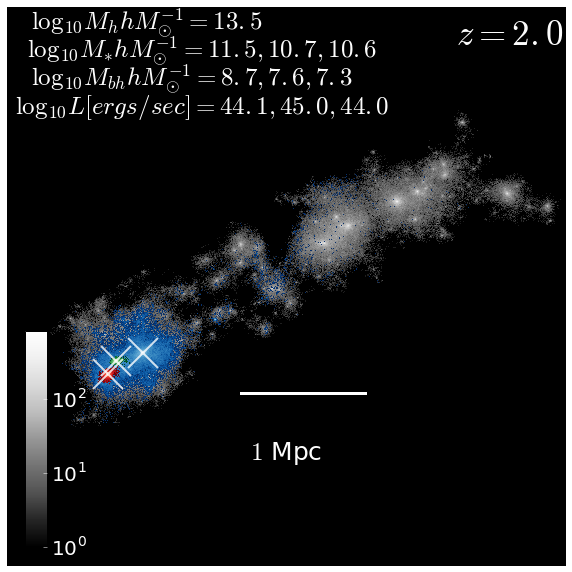

In [29]:

N_triplet=1

L_bol_cut=44.0
z=2.0
subhalo_id,halo_id,positions=pickle.load(open('./list_of_observable_triplets/system_%d_log_luminosity_cut%.1f_redshift_%.2f.pickle'%(N_triplet,L_bol_cut,z)))
f,ax=plt.subplots(1,1,figsize=(10,10))
make_image(halo_id[0],subhalo_id,positions,z,L_bol_cut,'xy')
plt.savefig('./figures_multiplicity_functions/triplet_%d_lcut%.1f_redshift%.1f.png'%(N_triplet,L_bol_cut,z),bbox_inches='tight')




Loading quasar data
Loading particle data
1.00000000106
Preparing the image
Halo mass of the host is:  14.088737985
Found galaxy hosting satellite quasar with stellar mass 11.8739423225  $M_{\odot}/h$
Found galaxy hosting satellite quasar with stellar mass 11.3677517706  $M_{\odot}/h$
Found galaxy hosting satellite quasar with stellar mass 11.1369434633  $M_{\odot}/h$


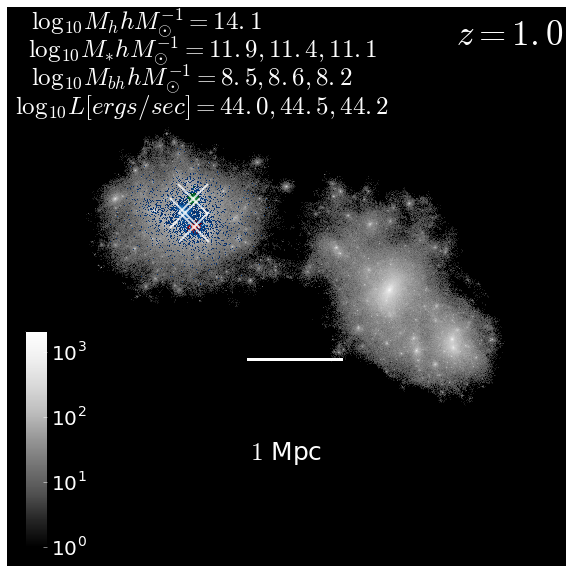

In [30]:

N_triplet=1

L_bol_cut=44.0
z=1.0
subhalo_id,halo_id,positions=pickle.load(open('./list_of_observable_triplets/system_%d_log_luminosity_cut%.1f_redshift_%.2f.pickle'%(N_triplet,L_bol_cut,z)))
f,ax=plt.subplots(1,1,figsize=(10,10))
make_image(halo_id[0],subhalo_id,positions,z,L_bol_cut,'xz')
plt.savefig('./figures_multiplicity_functions/triplet_%d_lcut%.1f_redshift%.1f.png'%(N_triplet,L_bol_cut,z),bbox_inches='tight')


Loading quasar data
Loading particle data
2.49999994818
Preparing the image
Halo mass of the host is:  13.3053678246
Found galaxy hosting satellite quasar with stellar mass 11.4262007949  $M_{\odot}/h$
Found galaxy hosting satellite quasar with stellar mass 10.8872210122  $M_{\odot}/h$
Found galaxy hosting satellite quasar with stellar mass 10.1197617821  $M_{\odot}/h$


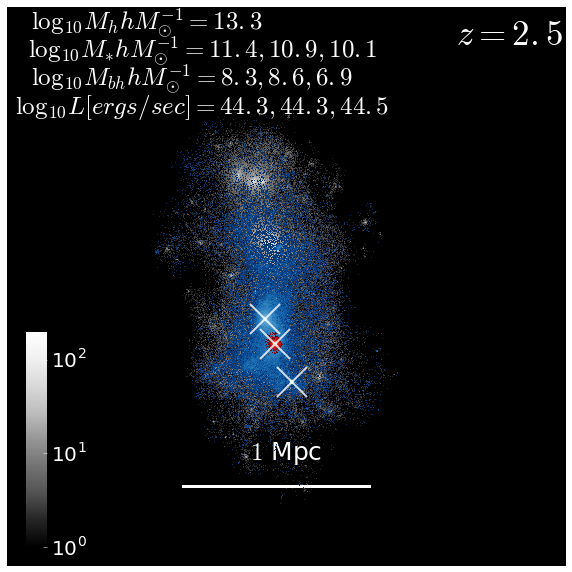

In [31]:
N_triplet=1

L_bol_cut=44.0
z=2.5
subhalo_id,halo_id,positions=pickle.load(open('./list_of_observable_triplets/system_%d_log_luminosity_cut%.1f_redshift_%.2f.pickle'%(N_triplet,L_bol_cut,z)))
f,ax=plt.subplots(1,1,figsize=(10,10))
make_image(halo_id[0],subhalo_id,positions,z,L_bol_cut,'xz')
plt.savefig('./figures_multiplicity_functions/triplet_%d_lcut%.1f_redshift%.1f.png'%(N_triplet,L_bol_cut,z),bbox_inches='tight')


Loading quasar data
Loading particle data
2.49999994818
Preparing the image
Halo mass of the host is:  13.1353241215
Found galaxy hosting satellite quasar with stellar mass 11.294835312  $M_{\odot}/h$
Found galaxy hosting satellite quasar with stellar mass 10.75172161  $M_{\odot}/h$
Found galaxy hosting satellite quasar with stellar mass 10.4826312042  $M_{\odot}/h$


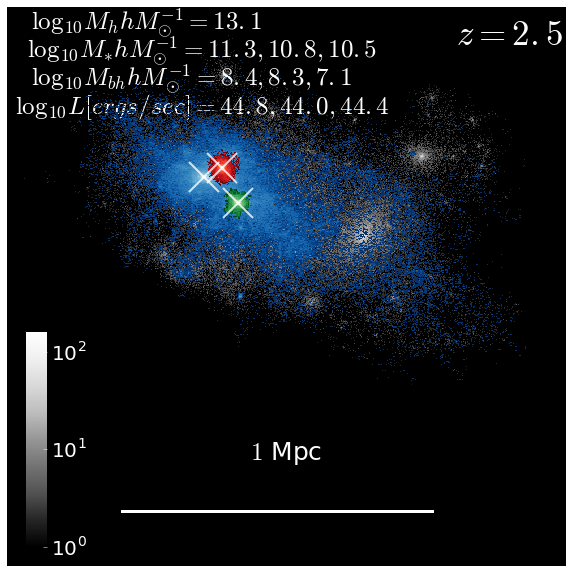

In [32]:

N_triplet=2

L_bol_cut=44.0
z=2.5
subhalo_id,halo_id,positions=pickle.load(open('./list_of_observable_triplets/system_%d_log_luminosity_cut%.1f_redshift_%.2f.pickle'%(N_triplet,L_bol_cut,z)))
f,ax=plt.subplots(1,1,figsize=(10,10))
make_image(halo_id[0],subhalo_id,positions,z,L_bol_cut,'xz')
plt.savefig('./figures_multiplicity_functions/triplet_%d_lcut%.1f_redshift%.1f.png'%(N_triplet,L_bol_cut,z),bbox_inches='tight')



Loading quasar data
Loading particle data
2.49999994818
Preparing the image
Halo mass of the host is:  12.9063980495
Found galaxy hosting satellite quasar with stellar mass 11.0169382517  $M_{\odot}/h$
Found galaxy hosting satellite quasar with stellar mass 10.6135969903  $M_{\odot}/h$
Found galaxy hosting satellite quasar with stellar mass 10.4553259671  $M_{\odot}/h$


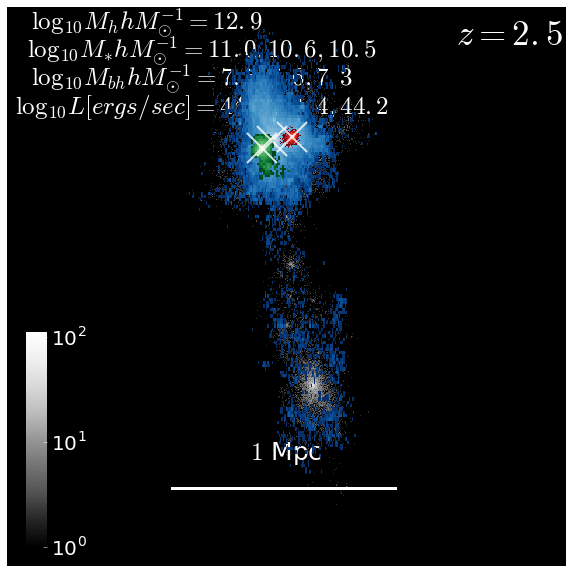

In [33]:

N_triplet=3

L_bol_cut=44.0
z=2.5
subhalo_id,halo_id,positions=pickle.load(open('./list_of_observable_triplets/system_%d_log_luminosity_cut%.1f_redshift_%.2f.pickle'%(N_triplet,L_bol_cut,z)))
f,ax=plt.subplots(1,1,figsize=(10,10))
make_image(halo_id[0],subhalo_id,positions,z,L_bol_cut,'xz')
plt.savefig('./figures_multiplicity_functions/triplet_%d_lcut%.1f_redshift%.1f.png'%(N_triplet,L_bol_cut,z),bbox_inches='tight')



Loading quasar data
Loading particle data
2.49999994818
Preparing the image
Halo mass of the host is:  12.7071611745
Found galaxy hosting satellite quasar with stellar mass 11.1466027762  $M_{\odot}/h$
Found galaxy hosting satellite quasar with stellar mass 10.59486723  $M_{\odot}/h$
Found galaxy hosting satellite quasar with stellar mass 9.90299028869  $M_{\odot}/h$


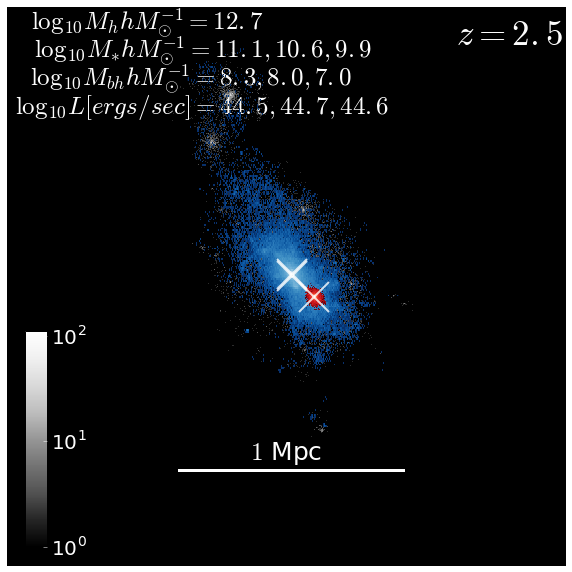

In [34]:

N_triplet=4

L_bol_cut=44.0
z=2.5
subhalo_id,halo_id,positions=pickle.load(open('./list_of_observable_triplets/system_%d_log_luminosity_cut%.1f_redshift_%.2f.pickle'%(N_triplet,L_bol_cut,z)))
f,ax=plt.subplots(1,1,figsize=(10,10))
make_image(halo_id[0],subhalo_id,positions,z,L_bol_cut,'xy')
plt.savefig('./figures_multiplicity_functions/triplet_%d_lcut%.1f_redshift%.1f.png'%(N_triplet,L_bol_cut,z),bbox_inches='tight')


Loading quasar data
Loading particle data
2.49999994818
Preparing the image
Halo mass of the host is:  13.2361126615
Found galaxy hosting satellite quasar with stellar mass 11.4335150237  $M_{\odot}/h$
Found galaxy hosting satellite quasar with stellar mass 10.7835898316  $M_{\odot}/h$
Found galaxy hosting satellite quasar with stellar mass 10.6189704385  $M_{\odot}/h$
Found galaxy hosting satellite quasar with stellar mass 10.2787616882  $M_{\odot}/h$


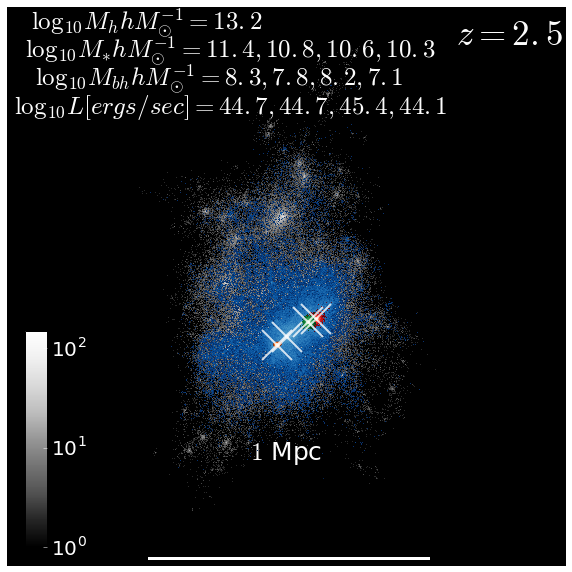

In [35]:

N_quadruplet=1

L_bol_cut=44.0
z=2.5
subhalo_id,halo_id,positions=pickle.load(open('./list_of_observable_quadruplets/system_%d_log_luminosity_cut%.1f_redshift_%.2f.pickle'%(N_quadruplet,L_bol_cut,z)))
f,ax=plt.subplots(1,1,figsize=(10,10))
make_image(halo_id[0],subhalo_id,positions,z,L_bol_cut,'xy')
plt.savefig('./figures_multiplicity_functions/quadruplet_%d_lcut%.1f_redshift%.1f.png'%(N_quadruplet,L_bol_cut,z),bbox_inches='tight')



Loading quasar data
Loading particle data
2.49999994818
Preparing the image
Halo mass of the host is:  13.0915539598
Found galaxy hosting satellite quasar with stellar mass 10.7037435945  $M_{\odot}/h$
Found galaxy hosting satellite quasar with stellar mass 10.4406784091  $M_{\odot}/h$
Found galaxy hosting satellite quasar with stellar mass 10.3500837519  $M_{\odot}/h$
Found galaxy hosting satellite quasar with stellar mass 10.0401634912  $M_{\odot}/h$


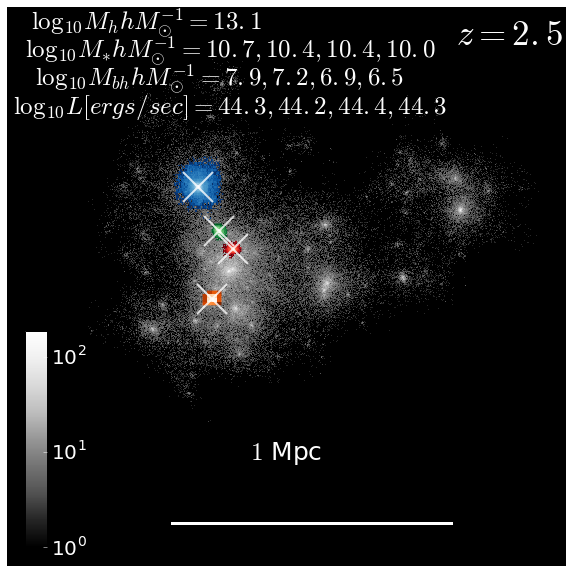

In [36]:

N_quadruplet=2

L_bol_cut=44.0
z=2.5
subhalo_id,halo_id,positions=pickle.load(open('./list_of_observable_quadruplets/system_%d_log_luminosity_cut%.1f_redshift_%.2f.pickle'%(N_quadruplet,L_bol_cut,z)))
f,ax=plt.subplots(1,1,figsize=(10,10))
make_image(halo_id[0],subhalo_id,positions,z,L_bol_cut,'xy')
plt.savefig('./figures_multiplicity_functions/quadruplet_%d_lcut%.1f_redshift%.1f.png'%(N_quadruplet,L_bol_cut,z),bbox_inches='tight')
